![Banner](./img/AI_Special_Program_Banner.jpg)


This notebook largely corresponds to an adaptation of chapter 11 from [Sebastian Raschka](https://www.packtpub.com/product/python-machine-learning/9781783555130), 2015

Related code [here](https://github.com/rasbt/python-machine-learning-book).

# Clustering
---

Clustering describes a class of methods that belong to *unsupervised learning*. This means that there is no previously known class assignment that the model should learn (as with *supervised learning*). Instead, we need a way to describe the *dissimilarity* between the data. The idea of clustering is to find groups of data where the data within the groups are similar, while the groups themselves are well distinguished and thus dissimilar.

## Table of contents
---

- [Grouping of similar objects with k-means](#Grouping-of-similar-objects-with-k-means)
  - [K-means++](#K-means++)
  - [Elbow method for identifying the optimal number of clusters](#Elbow-method-for-identifying-the-optimal-number-of-clusters)
  - [Quantification of cluster quality with silhouette plots](#Quantification-of-cluster-quality-with-silhouette-plots)
- [Organizing clusters as a hierarchical tree](#Organizing-clusters-as-a-hierarchical-tree)
  - [Performing hierarchical clustering on a distance matrix](#Performing-hierarchical-clustering-on-a-distance-matrix)
  - [Append dendrograms to a heatmap](#Append-dendrograms-to-a-heatmap)
  - [Agglomerative clustering with scikit learn](#Agglomerative-clustering-with-scikit-learn)
- [Localization of regions with high density with DBSCAN](#Localization-of-regions-with-high-density-with-DBSCAN)
- [Concluding remarks](#Concluding-remarks)
- [Learning outcomes](#Learning-outcomes)

## Grouping of similar objects with `k-means`
---

In [1]:
from IPython.display import Image

In [2]:
# For the reproducibility of the results
import numpy as np
np.random.seed(17)

*k-means* is the best-known method for clustering, which is why we will look at it here. It is very popular because, compared to other clustering algorithms, some of which we will look at later, it is comparatively easy to implement and yet computationally very efficient.

In k-means, the clusters are represented by their **centroids** (the *average*) or their **medoids** (most frequently occurring points). Therefore, k-means belongs to the class of **prototype-based** clustering algorithms. The algorithm proves to be very well suited for *circular* clusters. A major challenge in its application: finding $k$, i.e. the number of clusters that must be specified beforehand. A poorly chosen $k$ can lead to suboptimal performance. We will see later that there are ways to (semi-)automate the choice of $k$.

To illustrate how k-means works, we will look at an example with two-dimensional data. However, the algorithm can be applied in higher dimensions as well. We start with 150 randomly generated points belonging to three regions in which the individual points are grouped closer together.

In [3]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=150, 
                  n_features=2, 
                  centers=3, 
                  cluster_std=0.5, 
                  shuffle=True, 
                  random_state=0);

Here is the corresponding *scatterplot*:

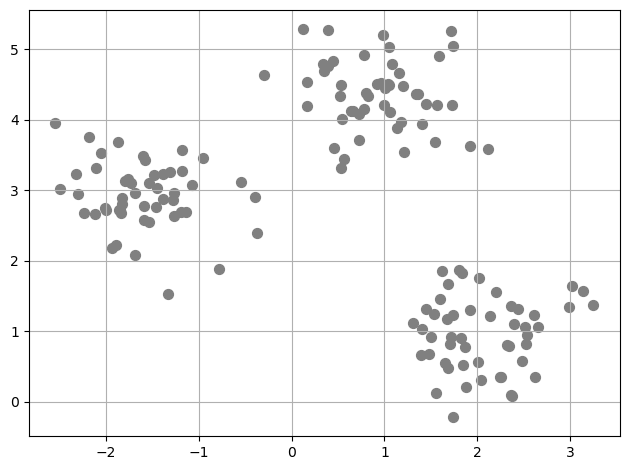

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(X[:,0], X[:,1], c='grey', marker='o', s=50)
plt.grid()
plt.tight_layout()
plt.show()

**Algorithm with 4 steps**:
1.	 Random selection of $k$ centroids from the data points as initial cluster centers.
2.	 Assignment of each point to the next centroid $\mu^{(j)} , j ∈ { 1, \dots , k }$.
3.	 Move the centroids to the center of the assigned points.
4.	 Repeat steps 2 and 3 until the assignment to a cluster no longer changes, or until a user-defined tolerance or a maximum number of iterations is reached.

A very clear visualization is provided by [Naftali Harris](https://www.naftaliharris.com/blog/visualizing-k-means-clustering/).

*How do we measure similarity*?

* Similarity $:=$ *opposite of distance*
* for continuous features use the **quadratic Euclidean distance**:
  Sample of points $x, y\in \mathbb{R}^m$
$$
d ( \mathbf{x} , \mathbf{y} ) = \sum_{l=1}^m ( x_l - y_l )^2 = \left\lVert{\mathbf{x} - \mathbf{y}}\right\rVert_2^2
$$
* Here: $l$ stands for the $l$-th dimension (characteristic column) of $x$ and $y$.

$ \longrightarrow $ k-means algorithm solves an **optimization problem**, i.e. is an *iterative method* for minimizing the **residual sum of squared errors within the clusters** (**within-cluster sum of squared errors (SSE)**; also **cluster inertia** or **distortion**):
$$
SSE = \sum_{i=1}^n\sum_{j=1}^k w^{ ( i, j ) }\left\lVert{\mathbf{x}^{(i)} - \mathbf{\mu}^{(j)}}\right\rVert_2^2
$$

* Here: Superscripts $i$ and $j$ for $i$-th data point and $j$-th cluster respectively
* $\mathbf{\mu}^{(j)}$ is the centroid of the cluster $j$ (=: $C_j$)
* Weights $w$:
$$ w^{ ( i, j )} = \begin{cases}1 & x^{ ( i )}  \in C_j\\ 0 & \text{otherwise}\end{cases}$$

**Application of k-means to the example**

In [5]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3, 
            init='random', # leave this out for k-means++ (see below)
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

**Visualization of the result**

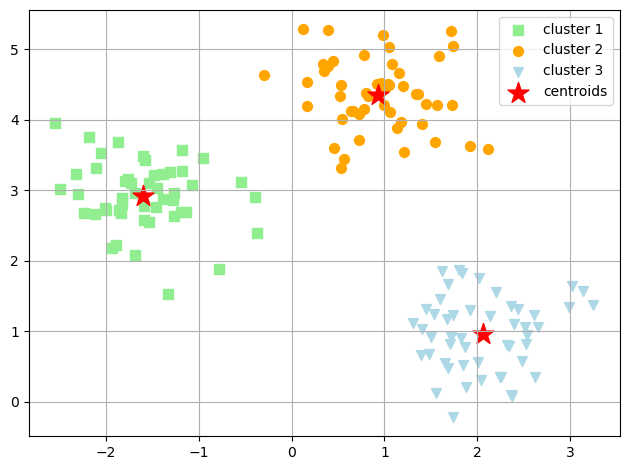

In [6]:
plt.scatter(X[y_km==0,0], 
            X[y_km==0,1], 
            s=50, 
            c='lightgreen', 
            marker='s', 
            label='cluster 1')
plt.scatter(X[y_km==1,0], 
            X[y_km==1,1], 
            s=50, 
            c='orange', 
            marker='o', 
            label='cluster 2')
plt.scatter(X[y_km==2,0], 
            X[y_km==2,1], 
            s=50, 
            c='lightblue', 
            marker='v', 
            label='cluster 3')
plt.scatter(km.cluster_centers_[:,0], 
            km.cluster_centers_[:,1], 
            s=250, 
            marker='*', 
            c='red', 
            label='centroids')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

<br>

### K-means++

Problem: possibly poor runtime behaviour due to random initialization of the centroids $\rightarrow$ Paper [*k-means++: The Advantages of Careful Seeding.*](http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf)

**Idea**: Define initial centroids away from each other $\longrightarrow$

* underlying assumption: distant points probably do not belong to the same cluster
* aimed at: higher probability for suitable centroids from the beginning

**Initialization of the k-means++ algorithm (qualitative)**

1. Start with empty set **M** to store the $k$ centroids
2. Choose first centroid $\mu^{(1)}$ again randomly from the data and add it **M**
3. For each data point $\mathbf{x}^{(i)}\notin \mathbf{M}$ determine $d(\mathbf{x}^{(i)}, \mathbf{M})^2$ (:= squared distance to **M**) as the minimum distance from $\mathbf{x}^{(i)}$ to the elements in **M**
4. Randomly choose the next centroid $\mu^{(p)}$ based on a weighted *probability distribution* according to
   $$
   \frac{d(\mathbf{\mu}^{(p)}, \mathbf{M})^2}{\sum_i d(\mathbf{x}^{(i)}, \mathbf{M})^2}
   $$
   (points further away thus have a higher probability of being selected)
5. Repeat steps 3. and 4. until $k$ centroids have been found.

Then continue with the usual k-means algorithm

### Elbow method for identifying the optimal number of clusters

* *Explorative analysis* due to lack of prior knowledge
* Quality assessment only *intrinsically* possible
* for k-means using SSE (here: **distortion**; in `scikit-learn` **inertia**)

In [7]:
print('Distortion: %.2f' % km.inertia_)

Distortion: 72.48


**Elbow idea**
* The more clusters, the less distortion (= none, if one cluster per data point)
* The latter is nonsense, as is $k=1$
* Question: is there a $k_{\text{opt}}$ at which the *decrease in distortion* is significantly lower than before?
    * if yes: probably good compromise between *under-* and *overfitting*
    * Expectation: good *generalization*
    
$\rightarrow$ try out different $k$ and plot distortion!

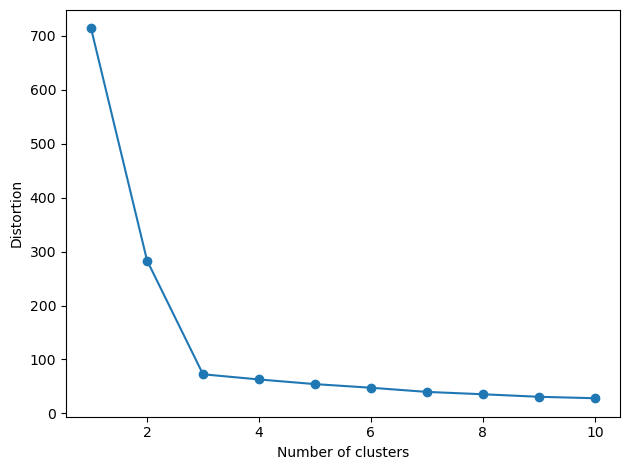

In [8]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, 
                init='k-means++', # this can be left out, as it is the default
                n_init=10, 
                max_iter=300, 
                random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)
plt.plot(range(1,11), distortions , marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()

In the example as $k_{\text{opt}}=3$ (as expected)

### Quantification of cluster quality with silhouette plots

1. *Cohesion* $a^{(i)}$: average distance of a data point $\mathbf{x}^{(i)}$ to all other data points in the cluster (similarity within the cluster)
2. *separation* $b^{(i)}$: average distance of a data point $\mathbf{x}^{(i)}$ to all data points in the nearest cluster to which $\mathbf{x}^{(i)}$ **does not** belong (dissimilarity to other clusters)
3. *Silhouette* $s^{(i)}$:
   $$
     s^{(i)} := \frac{b^{(i)} - a^{(i)}}{\text{max}\{b^{(i)},a^{(i)}\}}\quad\in[-1,1]
   $$
   
Ideally, $b^{(i)}>>a^{(i)} \rightarrow s^{(i)}\approx 1$

`silhouette_samples` available in `scikit-learn` (<tt>metric</tt> modules)!

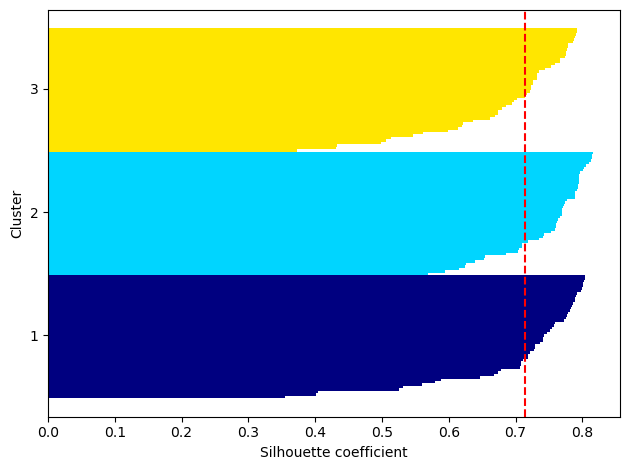

In [9]:
from matplotlib import cm
from sklearn.metrics import silhouette_samples

km = KMeans(n_clusters=3, 
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km==c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
            edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
plt.show()

Good, no silhouette value close to 0! so $k=3$ seems to be a good value.

#### Comparison with "bad" clustering:

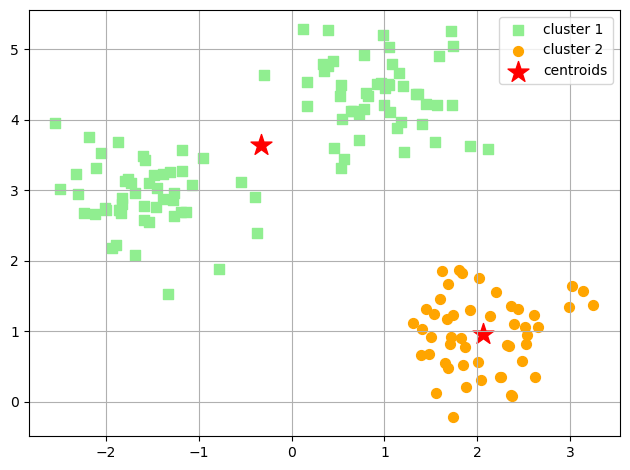

In [10]:
km = KMeans(n_clusters=2, 
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

plt.scatter(X[y_km==0,0], 
            X[y_km==0,1], 
            s=50, 
            c='lightgreen', 
            marker='s', 
            label='cluster 1')
plt.scatter(X[y_km==1,0], 
            X[y_km==1,1], 
            s=50, 
            c='orange', 
            marker='o', 
            label='cluster 2')

plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], s=250, marker='*', c='red', label='centroids')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

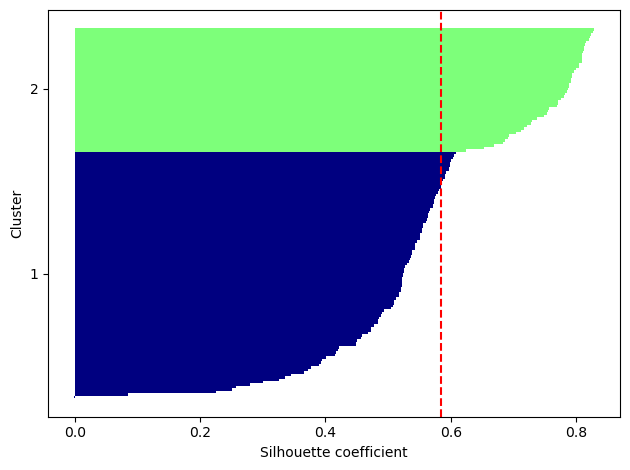

In [11]:
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km==c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
            edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
plt.show()

In cluster 1 data points with cohesion $\approx$ separation $\rightarrow$ not good!

**Note**: Silhouette plots can also be visualized if the data points have more than 2 dimensions (scatter plots dont work for this of course).

## Organizing clusters as a hierarchical tree
---

Advantages:
* Number of clusters does not have to be determined in advance
* easy to visualize with [dendrograms](https://www.displayr.com/what-is-dendrogram/) see below.

Two approaches:
* *divisive*: first all data points in one cluster, then split up to one cluster per data point
* *agglomerative*: first one cluster per data point, then aggregation until all are in one cluster

The actual number of clusters is then determined via a threshold value (possibly using a dendrogram).

**Criterion for cluster combination**: *linkage* (= *connection*) in the variants *single, complete, average, Ward's* and many more;

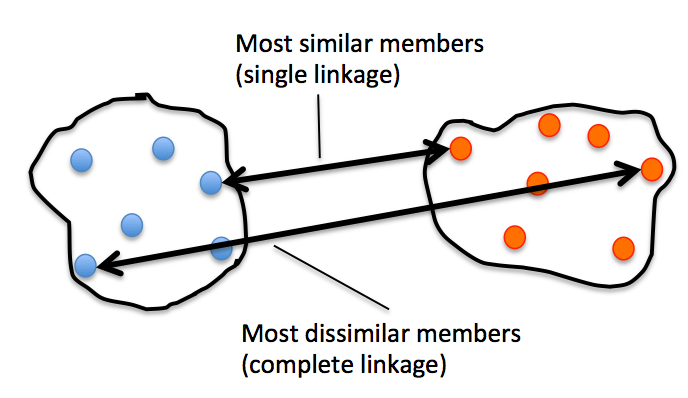

In [12]:
Image(filename='./img/11_05.png', width=400) 

Clusters are then formed according to the maximum / minimum distance with regard to the selected type of correlation.

**Agglomerative clustering**

Iterative procedure according to:
1. Calculate distance matrix for all data points
2. Each data point forms its own cluster
3. Merge the two clusters that are closest to each other in terms of the distance of the most different (=most dissimilar) members
4. Update the distance matrix
5. Repeat steps 3 and 4 until there is only one cluster left

**Example**
five random points ID_0, ..., ID_4 with three characteristics X, Y, Z:

In [13]:
import pandas as pd
import numpy as np

np.random.seed(123)

variables = ['X', 'Y', 'Z']
itemlabels = ['ID_0','ID_1','ID_2','ID_3','ID_4']

X = np.random.random_sample([5,3])*10
df = pd.DataFrame(X, columns=variables, index=itemlabels)
df

,X,Y,Z
ID_0,6.964692,2.861393,2.268515
ID_1,5.513148,7.194690,4.231065
ID_2,9.807642,6.848297,4.809319
ID_3,3.921175,3.431780,7.290497
ID_4,4.385722,0.596779,3.980443


<br>

### Performing hierarchical clustering on a distance matrix

Calculation of the distance matrix:

In [14]:
from scipy.spatial.distance import pdist,squareform
# Triangular form
row_pdist = pdist(df, metric='euclidean')
# Quadratic form
row_dist = pd.DataFrame(squareform(row_pdist), columns=itemlabels, index=itemlabels)
row_dist

,ID_0,ID_1,ID_2,ID_3,ID_4
ID_0,0.000000,4.973534,5.516653,5.899885,3.835396
ID_1,4.973534,0.000000,4.347073,5.104311,6.698233
ID_2,5.516653,4.347073,0.000000,7.244262,8.316594
ID_3,5.899885,5.104311,7.244262,0.000000,4.382864
ID_4,3.835396,6.698233,8.316594,4.382864,0.000000


Compare with the output of <tt>pdist</tt>:

In [15]:
# Show triangular form
row_pdist

array([4.973534  , 5.51665266, 5.89988504, 3.83539555, 4.34707339,
       5.10431109, 6.69823298, 7.24426159, 8.31659367, 4.382864  ])

Since the distance matrix is symmetrical with zeros on the diagonal, we only need the upper triangle values!

*Calculation of the **linkage matrix**:*

* allowed: triangular shape or original data
* **not**: square shape

In [16]:
# 1. incorrect approach: Squareform distance matrix

from scipy.cluster.hierarchy import linkage

row_clusters = linkage(row_dist, method='complete', metric='euclidean')
df1 = pd.DataFrame(row_clusters, 
             columns=['row label 1', 'row label 2', 'distance', 'no. of items in clust.'],
             index=['cluster %d' %(i+1) for i in range(row_clusters.shape[0])])
df1

/tmp/ipykernel_16122/103535267.py:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  row_clusters = linkage(row_dist, method='complete', metric='euclidean')


,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,6.521973,2.0
cluster 2,1.0,2.0,6.729603,2.0
cluster 3,3.0,5.0,8.539247,3.0
cluster 4,6.0,7.0,12.444824,5.0


In [17]:
# 2. correct approach: Condensed distance matrix

row_clusters = linkage(pdist(df, metric='euclidean'), method='complete')
df2 = pd.DataFrame(row_clusters, 
             columns=['row label 1', 'row label 2', 'distance', 'no. of items in clust.'],
             index=['cluster %d' %(i+1) for i in range(row_clusters.shape[0])])
df2

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.899885,3.0
cluster 4,6.0,7.0,8.316594,5.0


In [18]:
# 3. correct approach: Input sample matrix

row_clusters = linkage(df.values, method='complete', metric='euclidean')
df3 = pd.DataFrame(row_clusters, 
             columns=['row label 1', 'row label 2', 'distance', 'no. of items in clust.'],
             index=['cluster %d' %(i+1) for i in range(row_clusters.shape[0])])
df3

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.899885,3.0
cluster 4,6.0,7.0,8.316594,5.0


**Visualization: Dendrogram**

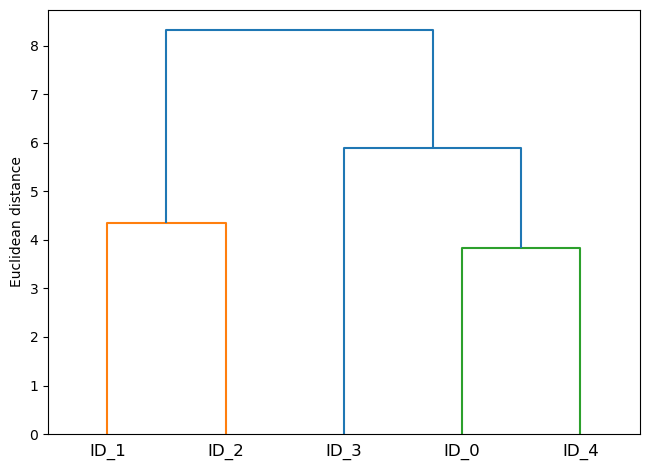

In [19]:
from scipy.cluster.hierarchy import dendrogram

# make dendrogram black (part 1/2)
# from scipy.cluster.hierarchy import set_link_color_palette
# set_link_color_palette(['black'])

row_dendr = dendrogram(row_clusters, 
                       labels=itemlabels,
                       # make dendrogram black (part 2/2)
                       # color_threshold=np.inf
                       )
plt.tight_layout()
plt.ylabel('Euclidean distance')
plt.show()

<br>

With a tolerance of 7, this results in two clusters: the first cluster contains <tt>[ID_1, ID_2]</tt> and the second cluster contains <tt>[ID_0, ID_3, ID_4]</tt>. For a tolerance of 5, there are three clusters: the first cluster contains <tt>[ID_1, ID_2]</tt>, the second cluster contains only <tt>[ID_3]</tt> and the third cluster contains <tt>[ID_0, ID_4]</tt>.

### Append dendrograms to a heatmap

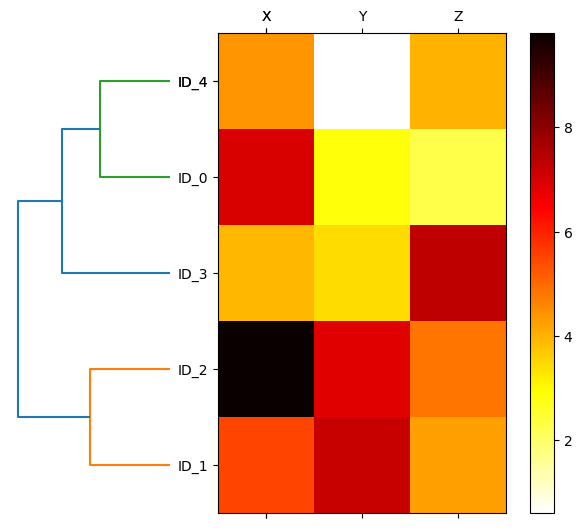

In [20]:
# plot row dendrogram
fig = plt.figure(figsize=(8,8), facecolor='white')
axd = fig.add_axes([0.09,0.1,0.2,0.6])

# note: for matplotlib < v1.5.1, please use orientation='right'
row_dendr = dendrogram(row_clusters, orientation='left')

# reorder data with respect to clustering
df_rowclust = df.iloc[row_dendr['leaves'][::-1]]

axd.set_xticks([])
axd.set_yticks([])

# remove axes spines from dendrogram
for i in axd.spines.values():
        i.set_visible(False)

# plot heatmap
axm = fig.add_axes([0.23,0.1,0.6,0.6]) # x-pos, y-pos, width, height
cax = axm.matshow(df_rowclust, interpolation='nearest', cmap='hot_r')
fig.colorbar(cax)
axm.set_xticks([0,0,1,2])
axm.set_xticklabels([''] + list(df_rowclust.columns))
axm.set_yticks([0,0,1,2,3,4])
axm.set_yticklabels([''] + list(df_rowclust.index))

plt.show()

<br>

This type of visualization makes the similarity of the data points in the cluster visible.

## Agglomerative clustering with scikit learn

In [21]:
from sklearn.cluster import AgglomerativeClustering

ac = AgglomerativeClustering(n_clusters=None, metric='euclidean', 
                             linkage='complete', distance_threshold=5.0)
labels = ac.fit_predict(X)
print('Cluster labels: %s' % labels)

Cluster labels: [1 0 0 2 1]


To plot a dendrogram from this, we can look at the corresponding example in [scikit-learn](https://github.com/scikit-learn/scikit-learn/blob/70cf4a676caa2d2dad2e3f6e4478d64bcb0506f7/examples/cluster/plot_hierarchical_clustering_dendrogram.py) and adapt it to our case:

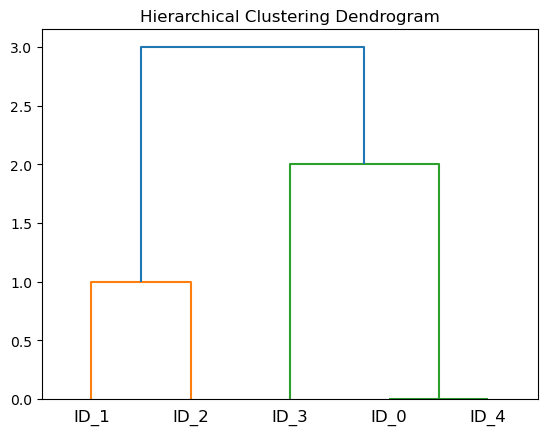

In [22]:
def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(ac, labels=itemlabels)
plt.show()

This leads to the same results as above, the only difference being the absolute distance values.

## Localization of regions with high density with DBSCAN
---

Density-based Spatial Clustering of Applications with Noise (DBSCAN)

+ Density (*density*) = number of points within a given radius $\varepsilon$
+ Core point (*core point*): at least a specified number $n_{\text{min}}$ of neighboring points lie within the radius $\varepsilon$
+ Border point (*border point*): has fewer than $n_{\text{min}}$ neighbors in the radius $\varepsilon$, but a core point lies in this radius
+ noise point (*noise point*): neither core point nor boundary point

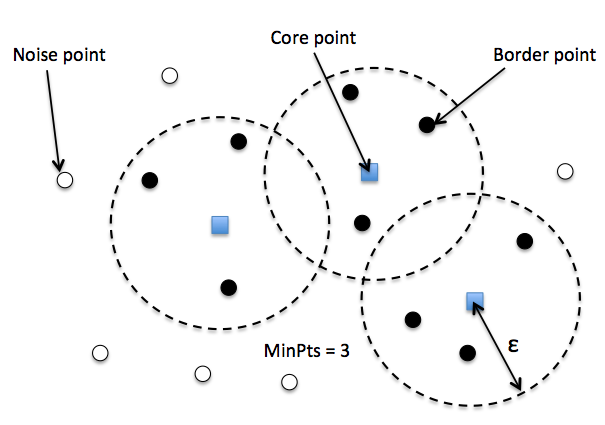

In [23]:
Image(filename='./img/11_11.png', width=500) 

**DBSCAN algorithm**

1. Categorize the data points as core, edge or noise points
2. Form a cluster for each core point or group of connected core points
    * Core points are *connected* if their distance is less than $\varepsilon$.
3. Edge points are assigned to the cluster of their associated core point.

*Advantages* of DBSCAN
* Clusters do not have to be circular
* Noise points are not assigned to a cluster $\rightarrow$ Outlier detection!

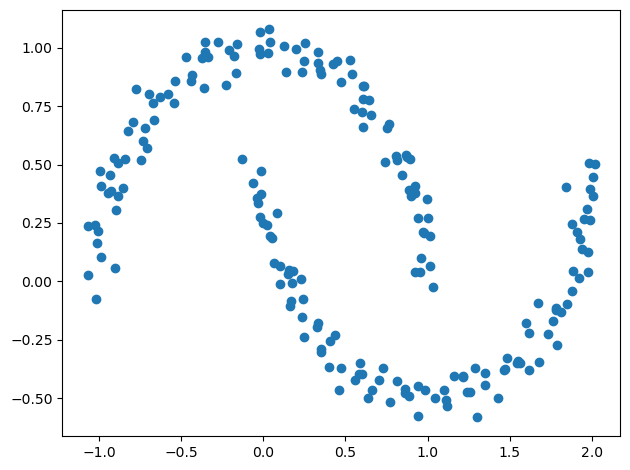

In [24]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=200, noise=0.05, random_state=0)
plt.scatter(X[:,0], X[:,1])
plt.tight_layout()
plt.show()

A person immediately recognizes two clusters, but...

#### k-means and hierarchical clustering:

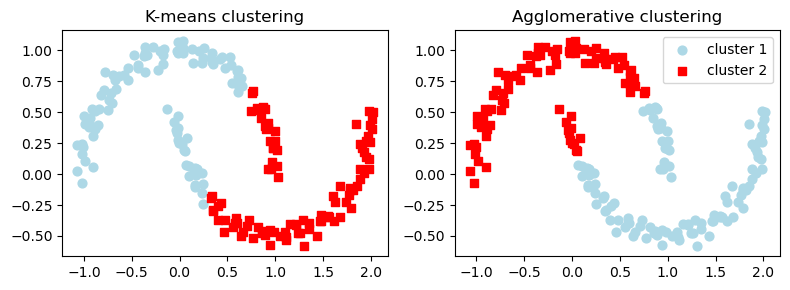

In [25]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))

km = KMeans(n_clusters=2, random_state=0, n_init=10)
y_km = km.fit_predict(X)
ax1.scatter(X[y_km==0,0], X[y_km==0,1], c='lightblue', marker='o', s=40, label='cluster 1')
ax1.scatter(X[y_km==1,0], X[y_km==1,1], c='red', marker='s', s=40, label='cluster 2')
ax1.set_title('K-means clustering')

#ac = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
ac = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='complete')
y_ac = ac.fit_predict(X)
ax2.scatter(X[y_ac==0,0], X[y_ac==0,1], c='lightblue', marker='o', s=40, label='cluster 1')
ax2.scatter(X[y_ac==1,0], X[y_ac==1,1], c='red', marker='s', s=40, label='cluster 2')
ax2.set_title('Agglomerative clustering')

plt.legend()
plt.tight_layout()
plt.show()

You can immediately recognize the circular clusters (due to the Euclidean distance).

#### Density-based clustering:

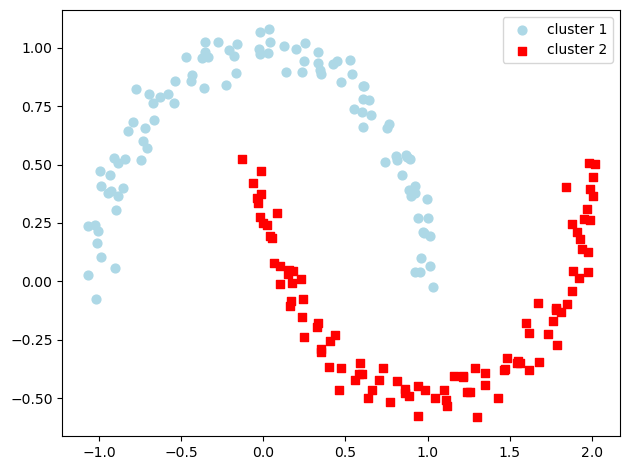

In [26]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.2, min_samples=5, metric='euclidean')
y_db = db.fit_predict(X)
plt.scatter(X[y_db==0,0], X[y_db==0,1], c='lightblue', marker='o', s=40, label='cluster 1')
plt.scatter(X[y_db==1,0], X[y_db==1,1], c='red', marker='s', s=40, label='cluster 2')
plt.legend()
plt.tight_layout()
plt.show()

That's how it should be, but...

*Disadvantages of DBSCAN*

- [curse of dimensionality](https://de.wikipedia.org/wiki/Fluch_der_Dimensionalit%C3%A4t) increasingly problematic the more features
- Optimizing hyperparameters $\varepsilon$ and $n_{\text{min}}$ $\rightarrow$ is not trivial

## Concluding remarks
---

* There are many other clustering algorithms. A good overview can be found at [scikit-learn](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py).
* Suitability and runtime behavior are problem-specific
* Hyperparameters must be optimized
* The choice of distance measure is crucial (see the documentation for [pdist-Function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html))
* **Essential** is the **standardization** or **normalization**
    * in the examples, all characteristics were of the same order of magnitude
    * in general, the data must be *prepared* for this
    * **necessary** for clustering due to distance calculation $\rightarrow$ dominance of features with larger values!
    * see also chapter 4 in Raschka's book or [Stackoverflow](https://stackoverflow.com/questions/15777201/why-vector-normalization-can-improve-the-accuracy-of-clustering-and-classificati)

## Learning outcomes
---

If you carefully studied the materials provided within this document, you should have a fundamental grasp of clustering in machine learning, including the following points:

* multiple types of clustering algorithms with their advantages and disadvantages,
* two ways to determine how many clusters could be used,
* visualizing clusters for 2D data (more in the exercise!)